In [64]:
from datetime import date, datetime, timedelta
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import ipywidgets as widgets


register_matplotlib_converters()
%matplotlib inline

In [65]:
df = None
last = datetime.now() - timedelta(hours=1)


def get_data():
    """
    Get the latest data. Just return the cached copy
    if less than one hour has elapsed.
    """
    global last, df
    now = datetime.now()
    if now - last < timedelta(hours=1):
        return df

    last = now    
    start = date(2020, 1, 22)
    end = date.today()

    df = pd.DataFrame()
    while start <= end:
        try:
            df_day = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{start.month:02d}-{start.day:02d}-{start.year}.csv')
            df_day['Date'] = start
            df = df.append(df_day)
        except Exception:
            pass
        start += timedelta(days=1)
    
    del df['Last Update']
    df = df.replace({'Country/Region': {'Mainland China': 'China'}})
    df.fillna({'Province/State': ''}, inplace=True)
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        df.fillna({col: 0}, inplace=True)
    return df

In [66]:
df = get_data()
df.tail(5)

,Confirmed,Country/Region,Date,Deaths,Latitude,Longitude,Province/State,Recovered
279,0.0,Guernsey,2020-03-18,0.0,49.4500,-2.580,,0.0
280,0.0,Jersey,2020-03-18,0.0,49.1900,-2.110,,0.0
281,0.0,Puerto Rico,2020-03-18,0.0,18.2000,-66.500,,0.0
282,0.0,Republic of the Congo,2020-03-18,0.0,-1.4400,15.556,,0.0
283,0.0,The Gambia,2020-03-18,0.0,13.4667,-16.600,,0.0


In [89]:
def aggregate_for_locations(df, locations, sub_loc=None, do_diffs=True, fields=None):
    if fields is None:
        fields = ['Confirmed', 'Deaths', 'Recovered']
    cols = ['Date']
    cols.extend(fields)
    
    if isinstance(locations, str):
        locations = [locations]
        
    if sub_loc:
        in_loc = df[(df['Country/Region'].isin(locations)) & (df['Province/State'] == sub_loc)]
    else:
        in_loc = df[df['Country/Region'].isin(locations)]
        
    result = in_loc[cols].groupby('Date').sum()
    
    if do_diffs:
        for f in fields:
            result[f] = result[f].diff()
            result.fillna({f: 0}, inplace=True)
    return result


In [68]:
def plot_time_series(df, title):
    fig, ax = plt.subplots()
    ax.plot_date(df.index, df, 'v-')
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1), interval=1))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    ax.legend(df.columns, loc='upper left', shadow=True)
    ax.set_title(title)
    plt.tight_layout()
    return plt

In [69]:
locations = sorted(list(df['Country/Region'].unique()))

In [70]:
picker = widgets.SelectMultiple(
                        options=locations,
                        value=['US'],
                        description='Locations'
                )

In [94]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location, do_diffs=False), 
                                                   title=f'{Location[0]}: Cumulative'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(181,), options=(' Azerbaijan', 'Afghanist…

<function __main__.<lambda>(Location)>

In [72]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location), title='New'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(181,), options=(' Azerbaijan', 'Afghanist…

<function __main__.<lambda>(Location)>

<module 'matplotlib.pyplot' from '/Users/grwheele/.pyenv/versions/3.7.5/envs/default/lib/python3.7/site-packages/matplotlib/pyplot.py'>

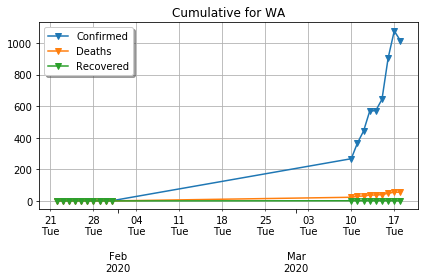

In [91]:
plot_time_series(aggregate_for_locations(df, 'US', sub_loc='Washington', do_diffs=False), title='Cumulative for WA')

<module 'matplotlib.pyplot' from '/Users/grwheele/.pyenv/versions/3.7.5/envs/default/lib/python3.7/site-packages/matplotlib/pyplot.py'>

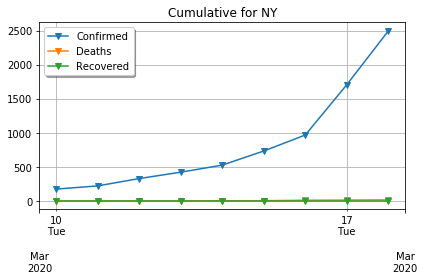

In [92]:
plot_time_series(aggregate_for_locations(df, 'US', sub_loc='New York', do_diffs=False), title='Cumulative for NY')